# Covid-19: From model prediction to model predictive control

## A demo of the deterministic modeling framework

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

Our code implements a SEIRS infectious disease dynamics model with extensions to model the effect of quarantining detected cases. Notably, this package includes stochastic implementations of these models on dynamic networks. We modified the original implementation by Ryan McGee at its source to account for additional Covid-19 disease characteristics. The code was then integrated with our previous work and allows to quickly perform Monte Carlo simulations, calibration of model parameters and the calculation of *optimal* government policies using a model predictive controller. A white paper and souce code of our previous work can be found on the Biomath website. 

https://biomath.ugent.be/covid-19-outbreak-modelling-and-control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
import coronaHelper2 as cH
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx
import models

## Introduction

### Model dynamics

In this work, we extended the SEIR model to model the disease spread with a higher resolution. To this end, the *infected pool* is split into four types of infectiousness: 1) supermild (SM): people who show little to no symptoms at all, 2) mild (M): people with noticable, mild symptoms, 3) heavy (H): people hospitalised but not in need of intensive care and 4) critical (C): people hospitalised and in need of intensive care. It takes several days before a heavy or critical infection becomes so severe that these patients need to be hospitalised. To this end, the pool of heavily and critically infected patients is split in two: not yet hospitalised (H, C) and hospitalised (HH,CH). The *removed pool* from the classical SEIR model is explicitly split into an immune (I) and dead (F) pool. People from the susceptible, exposed, supermild infected, mild infected and immune pool can be quarantined after having tested positive for covid-19. In the flowchart below, quarantine is denoted by the *Q*-suffix. Note that for individuals in the susceptible and immune pools, this corresponds to receiving a false positive test.

<img src="flowchart2.jpg"
     alt="flowchart"
     height="180" width="500"     
     style="float: left; margin-right: 500px;" /> 

### Deterministic vs. Stochastic framework

The extended SEIR model is implemented using two frameworks: a deterministic and a stochastic (network based) framework. A deterministic implementation of the extended SEIRS model captures important features of infectious disease dynamics, but it assumes uniform mixing of the population (i.e. every individual in the population is equally likely to interact with every other individual). The deterministic approach results in a set of N ordinary differential equations, one for every of the N ’population pools’ considered. The main advantage of the deterministic model is that a low amount of computational resources are required while still maintaining an acceptable accuracy. The deterministic framework allows to rapidly explore scenarios and perform optimisations which require thousands of function evaluations. 

However, it is often important to consider the structure of contact networks when studying disease transmission and the effect of interventions such as social distancing and contact tracing. The main drawback of the deterministic approach is the inability to simulate contact tracing, which is one of the most promising measures against the spread of sars-cov-2. For this reason, the SEIRS dynamics depicted in on the above flowchart are simulated on a stochastic dynamical network. This advantages include a more detailed analysis of the relationship between social network structure and effective transmission rates, including the effect of network-based interventions such as social distancing, quarantining, and contact tracing. The first drawback is the increased amount of computational resources required, leading to the inability to perform optimisations on a personal computer. Instead, high performance computing infrastructure is needed. The second drawback is the need for more data and/or assumptions on social interactions and how government measures affect these social interactions.

#### Deterministic equations
The dynamics of the deterministic system are mathematically formulated as the rate of change of each population pool shown in the above flowchart. This results in the following system of ordinary differential equations (subject to change),

\begin{eqnarray}
\dot{S} &=& - \beta \cdot N_c \Big( \frac{E+SM}{N} \Big) \cdot S  - \theta_{\text{S}} \psi_{\text{FP}} \cdot S + SQ/d_{\text{q,FP}} + \zeta \cdot R,\\
\dot{E} &=&  \beta \cdot N_c  \Big( \frac{E+SM}{N} \Big) \cdot S - B / \sigma - \theta_{\text{E}} \psi_{\text{PP}} \cdot E,\\
\dot{SM} &=& \text{sm}/\sigma  \cdot E - SM/d_{\text{sm}} - \theta_{\text{SM}} \psi_{\text{PP}} \cdot SM,\\ 
\dot{M} &=&  \text{m} / \sigma \cdot E - M/d_{\text{m}} - \theta_{\text{M}} \psi_{\text{PP}} \cdot M,\\
\dot{H} &=&  \text{h} / \sigma \cdot E + h / \sigma \cdot EQ - H/d_{\text{hospital}},\\
\dot{C} &=&  \text{c} / \sigma \cdot E + c / \sigma \cdot EQ - C/d_{\text{hospital}},\\
\dot{HH} &=& H/d_{\text{hospital}} - HH/d_{h}\\
\dot{CH} &=& C/d_{\text{hospital}} - m_c \cdot CH/d_{\text{cf}} - (1-m_c) \cdot CH/d_{\text{cr}}\\
\dot{F} &=& m_c \cdot CH/d_{\text{cf}}\\
\dot{R} &=& SM/d_{\text{sm}} + M/d_{\text{m}} + HH/d_{\text{h}} + (1-m_h) \cdot CH/d_{\text{cr}} + SMQ/d_{\text{sm}} \\ && + MQ/d_{\text{m}} + RQ/d_{\text{q,FP}} - \zeta \cdot R \\
\dot{SQ} &=& \theta_{\text{S}} \psi_{\text{FP}} \cdot S - SQ/d_{\text{q,FP}} \\
\dot{EQ} &=& \theta_{\text{E}} \psi_{\text{PP}} \cdot E - EQ/\sigma\\
\dot{SMQ} &=& \theta_{\text{SM}} \psi_{\text{PP}} \cdot SM + sm/\sigma \cdot EQ - SMQ/d_{\text{sm}} \\
\dot{MQ} &=& \theta_{\text{M}} \psi_{\text{PP}} \cdot M + m/\sigma \cdot EQ - MQ/d_{\text{m}}\\
\dot{RQ} &=& \theta_{\text{R}} \psi_{\text{FP}} \cdot R - RQ/d_{\text{q,FP}}
\end{eqnarray}

#### Stochastic equations
Consider a network graph G like the one depicted below, representing individuals (nodes) and their interactions (edges). Each individual (node) has a state (S, E, SM, M, H, C, HH, CH, R, F, SQ, SMQ, MQ or RQ). The set of nodes adjacent (connected by an edge) to an individual defines their set of "close contacts" (highlighted in black). At a given time, each individual makes contact with a random individual from their set of close contacts with probability (1-p) or with a random individual from anywhere in the network (highlighted in blue) with probability p. The latter global contacts represent individuals interacting with the population at large. These are individuals outside of ones inner social circle, such as on public transit, at an event or chatting to an old acquaintance etc. When a susceptible individual interacts with an exposed or infectious individual they become exposed themselves. The parameter p defines the locality of the network: for p=0 an individual only interacts with their close contacts, while p=1 represents a uniformly mixed population. **For a sufficiently large network G, and $p = 1$, the stochastic and deterministic framework will yield the same result**. Social distancing interventions ifluences both the locality and connectivity of the network. It is expected that social distancing lowers the average number of interactions an individual has each day (lower connectivity of the network). But as a result, the fraction of interactions in the inner circle increases, lowering p.

<img src="network_contacts.png"
     alt="network"
     height="180" width="300"     
     style="float: left; margin-right: 10000px;" /> 

Each node $i$ has a state $X_i$ that updates according to a probability transition rate. The dynamics of the stochastic system are mathematically formulated as probabilities of transitioning between the pools shown in the model flowchart. In addition, back tracking of confirmed cases can be included in the model,

\begin{eqnarray}
\text{Pr}(X_i = S \rightarrow E) &=&  \Big[ \underbrace{p \cdot \frac{\beta (E + SM)}{N}}_{\text{infection through random encounter}} \\ 
&& + \underbrace{(1-p) \cdot \frac{\beta \sum_{j \in C_G(i)} (\delta_{X_j = E}+\delta_{X_j = SM})}{C_G (i)}}_{\text{infection through inner circle}} \Big] \delta_{X_i=S},\\
\text{Pr}(X_i = E \rightarrow SM) &=&  (sm/\sigma) \cdot \delta_{X_i = E},\\
\text{Pr}(X_i = E \rightarrow M) &=&  (m/\sigma) \cdot \delta_{X_i = E},\\
\text{Pr}(X_i = E \rightarrow H) &=&  (h/\sigma) \cdot \delta_{X_i = E},\\
\text{Pr}(X_i = E \rightarrow C) &=&  (c/\sigma) \cdot \delta_{X_i = E},\\
\text{Pr}(X_i = H \rightarrow HH) &=&  (1/d_{\text{hospital}}) \delta_{X_i = H},\\
\text{Pr}(X_i = C \rightarrow CH) &=&  (1/d_{\text{hospital}}) \delta_{X_i = C},\\
\text{Pr}(X_i = SM \rightarrow R) &=& (1/d_{\text{sm}}) \cdot \delta_{X_i = SM},\\
\text{Pr}(X_i = M \rightarrow R) &=& (1/d_{\text{m}}) \cdot \delta_{X_i = M},\\
\text{Pr}(X_i = HH \rightarrow R) &=& (1/d_{\text{h}}) \cdot \delta_{X_i = HH},\\
\text{Pr}(X_i = CH \rightarrow R) &=& (1-m_c)/d_{\text{cr}} \cdot \delta_{X_i = HH},\\
\text{Pr}(X_i = CH \rightarrow F) &=& (m_c/d_{\text{cf}}) \cdot \delta_{X_i = HH},\\
\text{Pr}(X_i = S \rightarrow SQ) &=& \Big[\theta_S + \phi_S \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{FP}} \cdot \delta_{X_i = S}, \\
\text{Pr}(X_i = E \rightarrow EQ) &=& \Big[\theta_E + \phi_E \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{PP}} \cdot \delta_{X_i = E}, \\
\text{Pr}(X_i = SM \rightarrow SMQ) &=& \Big[\theta_{SM} + \phi_{SM} \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{PP}} \cdot \delta_{X_i = SM}, \\
\text{Pr}(X_i = M \rightarrow MQ) &=& \Big[\theta_{M} + \phi_{M} \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{PP}} \cdot \delta_{X_i = M} \\
\text{Pr}(X_i = R \rightarrow RQ) &=& \Big[\theta_{R} + \phi_{R} \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{FP}} \cdot \delta_{X_i = R}\\
\text{Pr}(X_i = SQ \rightarrow S) &=& (1/d_{q,FP}) \cdot \delta_{X_i = SQ},\\
\text{Pr}(X_i = EQ \rightarrow SMQ) &=& sm \cdot \sigma \cdot \delta_{X_i = EQ},\\
\text{Pr}(X_i = EQ \rightarrow MQ) &=& m \cdot \sigma \cdot \delta_{X_i = EQ},\\
\text{Pr}(X_i = EQ \rightarrow H) &=& h \cdot \sigma \cdot \delta_{X_i = EQ},\\
\text{Pr}(X_i = EQ \rightarrow C) &=& h \cdot \sigma \cdot \delta_{X_i = EQ},\\
\text{Pr}(X_i = SMQ \rightarrow R) &=& h (1/d_{sm}) \cdot \delta_{X_i = SMQ},\\
\text{Pr}(X_i = MQ \rightarrow R) &=& h (1/d_{m}) \cdot \delta_{X_i = MQ},\\
\text{Pr}(X_i = RQ \rightarrow R) &=& h (1/d_{\text{hospital}}) \cdot \delta_{X_i = RQ},\\
\text{Pr}(X_i = R \rightarrow S) &=& \zeta \cdot \delta_{X_i = R},\\
\end{eqnarray}

where $\delta_{X_i = A} = 1$ if the state of $X_i$ is A, or 0 if not, and where $C_G(i)$ denotes the set of close contacts of node i (adjacent nodes). For large populations and $p = 1$, this stochastic model approaches the same dynamics as the deterministic SEIRS model.

### Model parameters

In the above equations, S stands for susceptible, E for exposed, SM for supermild, M for mild, H for heavy, C for critical, HH for heavy and hospitalised, CH for critical and hospitalised, F for dead, R for immune. The quarantined states are SQ, which stands for susceptible and quarantined, EQ for exposed and quarantined, SMQ for supermild infected and quarantined, MQ for mildly infected and quarantined and RQ for recovered and quarantined. N stands for the total population. The clinical parameters are: sm, m, z, h: the chance of having a supermild, mild, heavy or critical infection. Based on reported cases in China and travel data, Li et al. (2020b) estimated that 86 % of coronavirus infections in the country were "undocumented" in the weeks before officials instituted stringent quarantines. In this work it is assumed that 86 % of all infected cases are supermild (asymptotic) and hence,

$$sm = 0.86$$

Based on previously reported estimates of the distribution between mild, severe and critical cases (Wu and McGoogan, 2020), it is then calculated that the chance of contrapting a mild, severe and critical infection is,

$$m = (1 − 0.86) · 0.81 = 0.1133,$$
$$h = (1 − 0.86) · 0.14 = 0.0193,$$
$$c = (1 − 0.86) · 0.05 = 0.0066.$$

$d_{sm}$ , $d_m$ , $d_h$ : the number of symptomic days in case of a supermild, mild or heavy infection. $d_{hf}$ is the time from hospitalisation until death in case of a critical infection while $d_{hr}$ is the recovery time for critical cases. Zhou et al. (2020) performed a retrospective study on 191 Chinese hospital patients and determined that the time from illness onset to discharge or death was 22.0 days (18.0-25.0, IQR) and 18.5 days (15.0-22.0, IQR) for survivors and victims respectively. Using available preliminary data, the World Health Organisation estimated the median time from onset to clinical recovery for mild cases to be approximately 2 weeks and to be 3-6 weeks for patients with severe or critical disease (WHO, 2020). Based on this report, we assume a recovery time of three weeks for heavy infections. d hospital : the time before heavily or critically infected patients reach the hospital. On average this is 9.1 days (Li et al., 2020a). m c : the mortality in case of a critical infection, which is roughly 50% (Wu and McGoogan, 2020). It is assumed that if the number of critical cases surpasses the total number of ICU beds, the mortality is changed to the average between 0.49 and 1, with the fraction of patients in critical condition receiving care as a weight. This is formulated mathematically in the following way,

\begin{equation}
m_h = \underbrace{\Big( \frac{ICU_{\text{max}}}{H} \Big) \cdot 0.49}_{\text{critical patient receives care}} + \underbrace{\Big( \frac{H - ICU_{\text{max}}}{H} \Big) \cdot 1.00}_{\text{critical patient receives no care}}\ .
\end{equation}

$\sigma$: the incubation period in days. The incubation period is assumed to be Erlang distributed as reported by Li et al. (2020a). The average incubation time is 5.2 days. $\zeta$: can be used to model the effect of re-susceptibility and seasonality of a disease. Throughout this demo, we assume $\zeta = 0$ because no data on re-susceptibility is available at the moment. We thus assume permanent immunity after recovering from the infection.

The transmission rate of the disease in the deterministic model depends on the product of three contributions. The first contribution, $(E+SM)/N$, is the probability of encountering a contagious individual. The second contribution, $N_c$, is the average number of human-to-human interactions per day. As previously explained, **in the deterministic framework, this means all $N_c$ contacts within the population are random**. In this work, we explictly split $\beta$ and $N_c$ because this has the following advantages:1) $\beta$ is now a disease characteric, independent of social interactions. 2) The goal of this work is to demonstrate the concept of social control to contain the outbreak using model predictive control. By splitting $\beta$ and $N_c$, the controlled variable is the number of random contacts $N_c$ which is more comprehendible to the reader of this text. The number of human-human interactions per day is estimated using the Social Contact Rates (SOCRATES) Data Tool (Willem et al., 2020). The dataset on human-human interactions for Belgium is based on a 2008 study by Mossong, which kept track of 750 participants and their interactions (8878 interactions) in Belgium. The dataset includes both physical and non-physical interactions of any duration. The third contribution, $\beta$, is the probability of contracting sars-cov-2 when encoutering a contagious individual. The testing and quarantine parameters are: $\theta_{S}$, $\theta_{E}$, $\theta_{SM}$, $\theta_{M}$, expressed as the number of susceptibles, exposed, supermild and mild individuals tested each day. $\psi_{PP}$: probability of correctly identifiying and quarantining an exposed or infected person. $\psi_{FP}$: probability of falsly identifying and quarantining a susceptible or recovered individual. Both parameters can be calculated using the reliability of the test and Bayes theorem. The latest reported reliability was only 71 \% (need ref). $d_{\text{q,FP}}$: the duration of the quarantine in the case of a false positive, assumed to be 14 days.

### Gathering social interaction data:

#### Social Contact Rates (SOCRATES) Data Tool

https://lwillem.shinyapps.io/socrates_rshiny/

1. What is the average number of daily human-to-human contacts of the Belgian population? Include all ages, all genders and both physical and non-physical interactions of any duration. To include all ages, type: *0,60+* in the *Age Breaks* dialog box.
2. What is the average number of physical human-to-human contacts of the Belgian population? Include all ages, all genders and all durations of physical contact.
3. What is the average number of physical human-to-human contacts of at least 1 hour of the Belgian population?
4. Based on the above results, how would you estimate $N_c$ in the deterministic model?
5. Based on the above results, how would you estimate $p$ in the stochastic model? Recall that $p$ is the fraction of *random contacts* a person has on a daily basis, while $(1-p)$ is the fraction of *inner circle contacts* a person has on a daily basis.

#### Google COVID-19 Community Mobility Reports

https://www.google.com/covid19/mobility/

#### London School of Hygiene

https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(20)30073-6/fulltext

In [2]:
# -----------------------
# Define model parameters
# -----------------------

# Clinical parameters
beta = 0.032 # already calibrated for the deterministic model, change to 0.29 for stochastic
Nc = np.array([[11.2]]) # average number of human-to-human contacts (USE SOCRATES TO DETERMINE VALUE)
zeta = 0 # re-susceptibility parameter (0 = permanent immunity)
dsm = 14 # length of disease for asymptotic (SM) infections
dm = 14 # length of disease for mildly symptomic infections
dhospital = 9.1 # average time from symptom onset to hospitalisation for H and C infections
dh = 21 # average recovery time for heavy infection
mc0 = 0.49 # mortality for critical cases when they receive care
ICU = 2600 # number of available ICU beds in Belgium

# Testing parameters
totalTests = 0
theta_S = 0 # no. of daily tests of susceptibles 
theta_E = 0 # no. of daily tests of exposed 
theta_SM = 0 # no. of daily tests of SM infected 
theta_M = 0 # no. of daily tests of M infected 
theta_R = 0 # no. of daily tests of recovered patients 
phi_S = 0 # backtracking of susceptibles
phi_E = 0 # backtracking of exposed
phi_SM = 0 # backtracking of supermild cases
phi_R = 0 # backtracking of recovered cases
psi_FP = 0 # odds of a false positive test
psi_PP = 1 # odds of a correct test
dq = 14 # length of quarantine for false positives

# Interessant artikel over serologische testen:
#https://www.tijd.be/dossiers/coronavirus/kunnen-bloedtests-onze-maatschappij-snel-weer-in-gang-trappen/10218259.html

## Performing simulations

#### Additional arguments to run a stochastic simulation

Before a stochastic simulation can be performed, two more parameters must be defined. The first is the interaction network G, which determines the connectivity of the network, the second is the parameter p, which determines the locality of the network. After defining both parameters, all stochastic-specific parameters are grouped in a dictionary *stoArgs*, which must be passed as an optional keyworded argument to the *simModel* function.

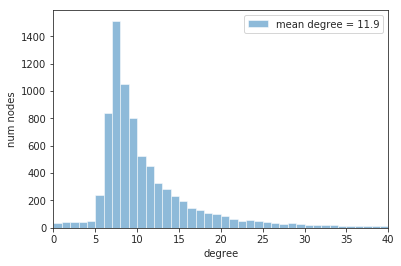

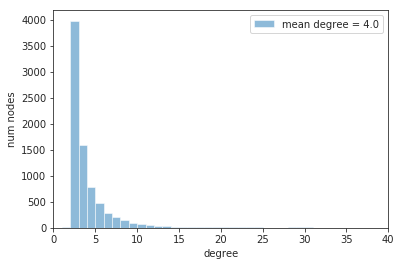

In [3]:
# Construct the network G
numNodes = 8000
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=7)
# Baseline normal interactions:
G_norm     = models.custom_exponential_graph(baseGraph, scale=200)
models.plot_degree_distn(G_norm, max_degree=40)

# Construct the network G under social distancing
numNodes = 8000
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=2)
# Baseline normal interactions:
G_dist     = models.custom_exponential_graph(baseGraph, scale=20000)
models.plot_degree_distn(G_dist, max_degree=40)

#### The use of checkpoints to change parameters on the fly

A cool feature of the original SEIRSplus package by Ryan McGee was the use of so-called *checkpoints* dictionary to change simulation parameters on the fly. In our modification, this feature is preserved. Below you can find an example of a *checkpoints* dictionary. The simulation will be started with the provided parameters. After 25 days, social interaction will be limited by changing beta to 0.10. After 85 days, social restrictions are lifted and beta once more assumes its *business-as-usual* value. When simulating a dynamic network, it is possible to change the connectivity of the network. In the example below, the connectivity is changed from an average of 12 interactions per day to only 4 interactions. If no checkpoints are needed, *checkpoints* should be set to *None*.

In [4]:
checkpoints = {'t':       [25,40,140], 
               'p':       [0.1,1-4.1/11.2,1-4.1/11.2],
               'G':       [G_dist,G_norm,G_norm],
               'totalTests': [0,1000000,1000000]
              }

#### Monte-Carlo sampling

One of the layers added to the existing SEIRSplus package is the ability to perform Monte-Carlo sampling of selected parameters. In our simulation, we assume four parameters are distributed: $s_m$, $d_{hf}$, $d_{hr}$ and $\sigma$.

In [5]:
monteCarlo = False # perform monte Carlo Sampling (recommend disabling for stochastic simulation)
n_samples = 400 # From 200 upwards no observable change 

In [6]:
# ------------------------
# Define initial condition
# ------------------------
initN = np.array([6e6])
initE= np.array([1])
initSM=np.zeros(1)
initM=np.zeros(1)
initH=np.zeros(1)
initC=np.zeros(1)
initHH=np.zeros(1)
initCH=np.zeros(1)
initR=np.zeros(1)
initF=np.zeros(1)
initSQ=np.zeros(1)
initEQ=np.zeros(1)
initSMQ=np.zeros(1)
initMQ=np.zeros(1)
initRQ=np.zeros(1)


# ----------------------------
# Define simulation parameters
# ----------------------------
simtime = 300 # length of simulation (days)
modelType = 'deterministic' # alternative: stochastic
method = 'none' # default

In [7]:
# --------------
# Run simulation
# --------------
simout=cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,totalTests,
                   psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC,initHH,initCH,
                   initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,n_samples,method,
                   modelType,checkpoints,**stoArgs)

AttributeError: 'SEIRSAgeModel' object has no attribute 'sumS'

In [8]:
# -----------
# Plot result
# -----------
t = simout['t']
I = simout['SM']+ simout['M'] + simout['H'] + simout['C'] + simout['HH'] + simout['CH']

plt.figure(1)
plt.plot(t,np.mean(simout['S'],axis=1),color="black")
plt.fill_between(t, np.percentile(simout['S'],90,axis=1), np.percentile(simout['S'],10,axis=1),color="black",alpha=0.2)
plt.plot(t,np.mean(simout['E'],axis=1),color="blue")
plt.fill_between(t, np.percentile(simout['E'],90,axis=1), np.percentile(simout['E'],10,axis=1),color="blue",alpha=0.2)
plt.plot(t,np.mean(I,axis=1),color="red")
plt.fill_between(t, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.mean(simout['R'],axis=1),color="green")
plt.fill_between(t, np.percentile(simout['R'],90,axis=1), np.percentile(simout['R'],10,axis=1),color="green",alpha=0.2)
plt.legend(('susceptible','exposed','total infected','immune'))
plt.xlabel('days')
plt.ylabel('number of patients')

plt.figure(2)
plt.plot(t,np.mean(simout['HH'],axis=1),color="orange")
plt.fill_between(t, np.percentile(simout['HH'],90,axis=1), np.percentile(simout['HH'],10,axis=1),color="orange",alpha=0.2)
plt.plot(t,np.mean(simout['CH'],axis=1),color="red")
plt.fill_between(t, np.percentile(simout['CH'],90,axis=1), np.percentile(simout['CH'],10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.mean(simout['F'],axis=1),color="black")
plt.fill_between(t, np.percentile(simout['F'],90,axis=1), np.percentile(simout['F'],10,axis=1),color="black",alpha=0.2)
plt.xlabel('days')
plt.ylabel('number of patients')

# vlines=checkpoints['t']
# vline_colors=['red','green','black','black']
# vline_labels=[]
# vline_styles=[]
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # Draw the vertical line annotations:
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# if(len(vlines)>0 and len(vline_colors)==0):
#     vline_colors = ['black']*len(vlines)
# if(len(vlines)>0 and len(vline_labels)==0):
#      vline_labels = [None]*len(vlines)
# if(len(vlines)>0 and len(vline_styles)==0):
#     vline_styles = [':']*len(vlines)
# for vline_x, vline_color, vline_style, vline_label in zip(vlines, vline_colors, vline_styles, vline_labels):
#         if(vline_x is not None):
#             plt.axvline(x=vline_x, color=vline_color, linestyle=vline_style, alpha=1, label=vline_label)

plt.legend(('heavy','critical','dead','start lockdown','end lockdown'))

plt.figure(3)
plt.plot(t,np.mean(simout['SQ'],axis=1),color="green")
plt.fill_between(t, np.percentile(simout['SQ'],90,axis=1), np.percentile(simout['SQ'],10,axis=1),color="green",alpha=0.2)
plt.plot(t,np.mean(simout['EQ'],axis=1),color="orange")
plt.fill_between(t, np.percentile(simout['EQ'],90,axis=1), np.percentile(simout['EQ'],10,axis=1),color="orange",alpha=0.2)
plt.plot(t,np.mean(simout['SMQ'],axis=1),color="red")
plt.fill_between(t, np.percentile(simout['SMQ'],90,axis=1), np.percentile(simout['SMQ'],10,axis=1),color="red",alpha=0.2)
plt.legend(('SQ','EQ','SMQ'))
plt.xlabel('days')
plt.ylabel('number of patients')

plt.figure(4)
plt.plot(t,np.mean(simout['M'],axis=1),color="red")
plt.fill_between(t, np.percentile(simout['M'],90,axis=1), np.percentile(simout['M'],10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.mean(simout['MQ'],axis=1),color="green")
plt.fill_between(t, np.percentile(simout['MQ'],90,axis=1), np.percentile(simout['MQ'],10,axis=1),color="green",alpha=0.2)
plt.legend(('M','MQ','number of tests on S'))
plt.xlabel('days')
plt.ylabel('number of patients')

NameError: name 'simout' is not defined

## Calibrating $\beta$  in a *business-as-usual* scenario ($N_c = 11.2$)

In [9]:
modelType = 'deterministic'

In [10]:
columns = ['hospital','ICU','dead']
hospital = np.array([[58,97,163,264,368,496,648,841,1096,1380,1643,1881,2137,2715,3068,3640,4077,4468,4884,4975,5206,5358,5492,5509,5600,5738,5692,5590,5610,5635,5409,5393,5536]])
ICUvect= np.array([[5,24,33,53,79,100,130,164,238,290,322,381,474,605,690,789,867,927,1021,1088,1144,1205,1245,1261,1257,1260,1276,1285,1278,1262,1232,1234,1223]])
dead = np.array([[3,4,4,10,10,14,21,37,67,75,88,122,178,220,289,353,431,513,705,828,1011,1143,1283,1447,1632,2035,2240,2523,3019,3346,3600,3903,4157]])
index=pd.date_range('2020-03-13', freq='D', periods=ICUvect.size)
data = np.concatenate((hospital,ICUvect,dead),axis=0)
data = np.transpose(data)
data_belgie=pd.DataFrame(data,index=index, columns=columns)

In [37]:
betaZonderIngrijpen=[]

In [51]:
# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = False
n_samples = 100
maxiter=30
popsize=5
polish=True
disp = True
bounds=[(0.01,0.05),(1,60)]
idx=-22
print(index[idx])
idx = idx+1
data=np.transpose(ICUvect[:,0:idx])
method = 'findTime'
modelType = 'deterministic'
checkpoints=None
fitTo = np.array([8]) #positions in output of runSimulation that must be added together, here: CH

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,initN,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,totalTests,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,monteCarlo,n_samples,method,modelType,checkpoints,disp,polish,maxiter,popsize)
betaZonderIngrijpen.append(estimate[0])
print(estimate)

2020-03-24 00:00:00


/home/twallema/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 115802
differential_evolution step 2: f(x)= 75693.2
differential_evolution step 3: f(x)= 75693.2
differential_evolution step 4: f(x)= 70107.6
differential_evolution step 5: f(x)= 44227
differential_evolution step 6: f(x)= 23912.3
differential_evolution step 7: f(x)= 12047.1
differential_evolution step 8: f(x)= 8827.33
differential_evolution step 9: f(x)= 5751.76
differential_evolution step 10: f(x)= 5751.76
differential_evolution step 11: f(x)= 4390.76
differential_evolution step 12: f(x)= 4390.76
differential_evolution step 13: f(x)= 4390.76
differential_evolution step 14: f(x)= 4390.76
differential_evolution step 15: f(x)= 4390.76
differential_evolution step 16: f(x)= 4390.76
differential_evolution step 17: f(x)= 4390.76
differential_evolution step 18: f(x)= 4390.76
differential_evolution step 19: f(x)= 4390.76
differential_evolution step 20: f(x)= 4390.76
differential_evolution step 21: f(x)= 4389.06
differential_evolution step 22: f(x)= 4388.69


In [52]:
estimate=[0.0311, 35.99]
beta = estimate[0]
extraTime = estimate[1]

In [13]:
obj = index[0]
timestampStr = obj.strftime("%Y-%m-%d")
print(timestampStr)

2020-03-13


<Figure size 432x288 with 0 Axes>

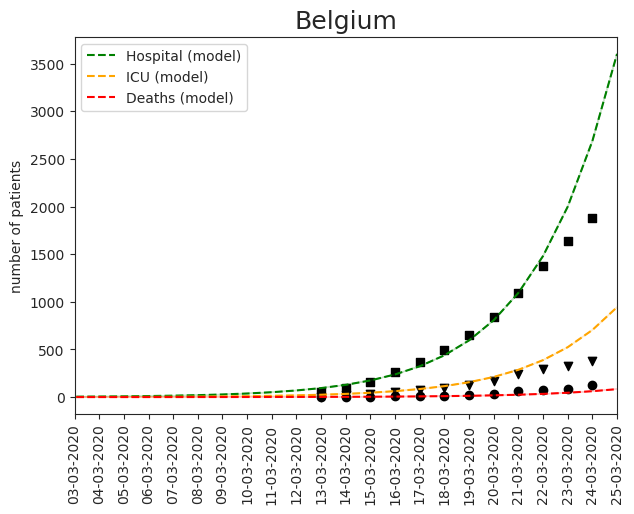

In [53]:
# -----------------------
# Fitted model parameters
# -----------------------
beta = estimate[0]
extraTime = estimate[1]
simtime=data.size+int(extraTime)-1
method = 'none'

# inital condition
initN = initN
initE = np.ones(Nc.shape[0])
initSM = np.zeros(Nc.shape[0])
initM = np.zeros(Nc.shape[0])
initH = np.zeros(Nc.shape[0])
initC = np.zeros(Nc.shape[0])
initHH = np.zeros(Nc.shape[0])
initCH = np.zeros(Nc.shape[0])
initR = np.zeros(Nc.shape[0])
initF = np.zeros(Nc.shape[0])
initSQ = np.zeros(Nc.shape[0])
initEQ = np.zeros(Nc.shape[0])
initSMQ = np.zeros(Nc.shape[0])
initMQ = np.zeros(Nc.shape[0])
initRQ = np.zeros(Nc.shape[0])    

# --------------
# Run simulation
# --------------
simout = cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,
                     theta_R,totalTests,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC, 
                    initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,
                     n_samples,method,modelType,checkpoints)

# -----------
# Plot result
# -----------
t=pd.date_range('2020-03-13', freq='D', periods=data.size)
tacc=pd.date_range('2020-03-13', freq='D', periods=data.size+int(extraTime))-datetime.timedelta(days=int(extraTime)-1)
fig=plt.figure(1)
plt.figure(figsize=(7,5),dpi=100)
plt.scatter(t,data_belgie.iloc[:idx,1],color="black",marker="v")
plt.scatter(t,data_belgie.iloc[:idx,2],color="black",marker="o")
plt.scatter(t,data_belgie.iloc[:idx,0],color="black",marker="s")

plt.plot(tacc,np.mean(simout['HH']+simout['CH'],axis=1),'--',color="green")
plt.fill_between(tacc,np.percentile(simout['HH']+simout['CH'],95,axis=1),
                 np.percentile(simout['HH']+simout['CH'],5,axis=1),color="green",alpha=0.2)

plt.plot(tacc,np.mean(simout['CH'],axis=1),'--',color="orange")
plt.fill_between(tacc,np.percentile(simout['CH'],95,axis=1),
                 np.percentile(simout['CH'],5,axis=1),color="orange",alpha=0.2)

plt.plot(tacc,np.mean(simout['F'],axis=1),'--',color="red")
plt.fill_between(tacc,np.percentile(simout['F'],95,axis=1),
                 np.percentile(simout['F'],5,axis=1),color="red",alpha=0.20)
plt.legend(('Hospital (model)','ICU (model)','Deaths (model)'),loc='upper left')

plt.xlim(pd.to_datetime(tacc[24]),pd.to_datetime(tacc[-1]))
plt.title('Belgium',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

plt.savefig('belgiumFit.svg',dpi=100,bbox_inches='tight')

## Model predictive control (use deterministic model)

### Bring model to current outbreak state

Text(0, 0.5, 'number of patients')

<Figure size 432x288 with 0 Axes>

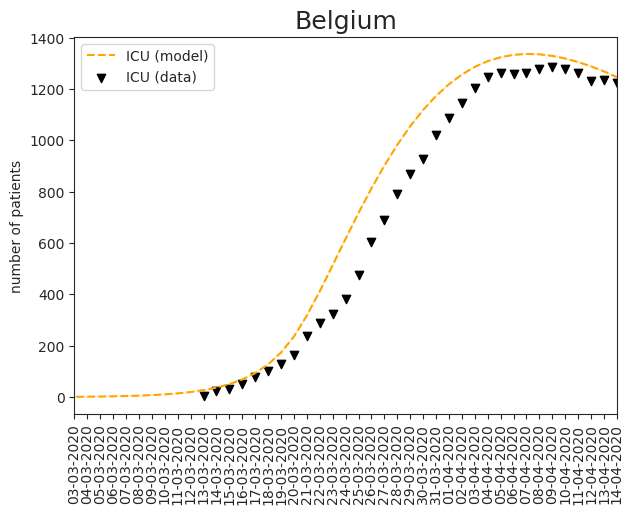

In [46]:
# -----------------------
# Define model parameters
# -----------------------

# Clinical parameters
#beta = 0.032 # already calibrated for the deterministic model, change to 0.29 for stochastic
Nc = np.array([[11.2]]) # average number of human-to-human contacts (USE SOCRATES TO DETERMINE VALUE)
zeta = 0 # re-susceptibility parameter (0 = permanent immunity)
dsm = 14 # length of disease for asymptotic (SM) infections
dm = 14 # length of disease for mildly symptomic infections
dhospital = 9.1 # average time from symptom onset to hospitalisation for H and C infections
dh = 21 # average recovery time for heavy infection
mc0 = 0.49 # mortality for critical cases when they receive care
ICU = 2600 # number of available ICU beds in Belgium

# Testing parameters
totalTests = 0
theta_S = 0 # no. of daily tests of susceptibles 
theta_E = 0 # no. of daily tests of exposed 
theta_SM = 0 # no. of daily tests of SM infected 
theta_M = 0 # no. of daily tests of M infected 
theta_R = 0 # no. of daily tests of recovered patients 
phi_S = 0 # backtracking of susceptibles
phi_E = 0 # backtracking of exposed
phi_SM = 0 # backtracking of supermild cases
phi_R = 0 # backtracking of recovered cases
psi_FP = 0 # odds of a false positive test
psi_PP = 1 # odds of a correct test
dq = 14 # length of quarantine for false positives

# Interessant artikel over serologische testen:
#https://www.tijd.be/dossiers/coronavirus/kunnen-bloedtests-onze-maatschappij-snel-weer-in-gang-trappen/10218259.html

monteCarlo = False # perform monte Carlo Sampling (recommend disabling for stochastic simulation)
n_samples = 400 # From 200 upwards no observable change 

# ------------------------
# Define initial condition
# ------------------------
initN = np.array([11.43e6])
initE= np.array([1])
initSM=np.zeros(1)
initM=np.zeros(1)
initH=np.zeros(1)
initC=np.zeros(1)
initHH=np.zeros(1)
initCH=np.zeros(1)
initR=np.zeros(1)
initF=np.zeros(1)
initSQ=np.zeros(1)
initEQ=np.zeros(1)
initSMQ=np.zeros(1)
initMQ=np.zeros(1)
initRQ=np.zeros(1)


# ----------------------------
# Define simulation parameters
# ----------------------------
simtime=ICUvect.size+int(extraTime)-1 # simuleer tot vandaag
modelType = 'deterministic' # alternative: stochastic
method = 'none' # default
checkpoints={
    't': [39+3],
    'Nc': [np.array([0.3])] #1.78
}

# --------------
# Run simulation
# --------------
simout=cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,totalTests,
                   psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC,initHH,initCH,
                   initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,n_samples,method,
                   modelType,checkpoints,**stoArgs)

# -----------
# Plot result
# -----------
t=pd.date_range('2020-03-13', freq='D', periods=ICUvect.size)
tacc=pd.date_range('2020-03-13', freq='D', periods=ICUvect.size+int(extraTime))-datetime.timedelta(days=int(extraTime))
fig=plt.figure(1)
plt.figure(figsize=(7,5),dpi=100)
plt.scatter(t,data_belgie.iloc[:,1],color="black",marker="v")
plt.plot(tacc,np.mean(simout['CH'],axis=1),'--',color="orange")
plt.fill_between(tacc,np.percentile(simout['CH'],95,axis=1),
                 np.percentile(simout['CH'],5,axis=1),color="orange",alpha=0.2)

plt.legend(('ICU (model)','ICU (data)'),loc='upper left')

plt.xlim(pd.to_datetime(tacc[24]),pd.to_datetime(tacc[-1]))
plt.title('Belgium',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

In [44]:
# Extract initial condition

initN = np.array([11.43e6])
initE= np.ones(1)*np.mean(simout['E'],axis=1)[-1]
initSM=np.ones(1)*np.mean(simout['SM'],axis=1)[-1]
initM=np.ones(1)*np.mean(simout['M'],axis=1)[-1]
initH=np.ones(1)*np.mean(simout['H'],axis=1)[-1]
initC=np.ones(1)*np.mean(simout['C'],axis=1)[-1]
initHH=np.ones(1)*np.mean(simout['HH'],axis=1)[-1]
initCH=np.ones(1)*np.mean(simout['CH'],axis=1)[-1]
initR=np.ones(1)*np.mean(simout['R'],axis=1)[-1]
initF=np.ones(1)*np.mean(simout['F'],axis=1)[-1]
initSQ=np.ones(1)*np.mean(simout['SQ'],axis=1)[-1]
initEQ=np.ones(1)*np.mean(simout['EQ'],axis=1)[-1]
initSMQ=np.ones(1)*np.mean(simout['SMQ'],axis=1)[-1]
initMQ=np.ones(1)*np.mean(simout['MQ'],axis=1)[-1]
initRQ=np.ones(1)*np.mean(simout['RQ'],axis=1)[-1]
print(initCH)
print(initR)

[1650.47821057]
[409768.92313793]


### Optimise the controller

In [38]:
modelType = 'deterministic'
method = 'none'

In [39]:
monteCarlo = False
n_samples=100
period = 7
P = 20
N = 16
discrete=False
roundOff = (0,1,2)
ICU = initCH

In [40]:
polish=True
disp = True
maxiter = 100
popsize = 10
phi_S = 0
phi_E = 0
phi_SM = 0
phi_R = 0
totalTests = 0
policy = cH.MPCoptimize(initN,beta,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,totalTests,
                        psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC,initHH,initCH,
                        initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,n_samples,method,
                        modelType,discrete,roundOff,period,P,N,disp,polish,maxiter,popsize)

/home/twallema/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 3.99606e+08
differential_evolution step 2: f(x)= 6.66733e+06
differential_evolution step 3: f(x)= 6.66733e+06
differential_evolution step 4: f(x)= 6.66733e+06
differential_evolution step 5: f(x)= 6.66733e+06
differential_evolution step 6: f(x)= 6.66733e+06
differential_evolution step 7: f(x)= 6.66733e+06
differential_evolution step 8: f(x)= 5.80729e+06
differential_evolution step 9: f(x)= 5.80729e+06
differential_evolution step 10: f(x)= 5.80729e+06
differential_evolution step 11: f(x)= 5.80729e+06
differential_evolution step 12: f(x)= 5.80729e+06
differential_evolution step 13: f(x)= 5.80729e+06
differential_evolution step 14: f(x)= 5.80729e+06
differential_evolution step 15: f(x)= 5.80729e+06
differential_evolution step 16: f(x)= 5.80729e+06
differential_evolution step 17: f(x)= 5.80729e+06
differential_evolution step 18: f(x)= 5.80729e+06
differential_evolution step 19: f(x)= 5.80729e+06
differential_evolution step 20: f(x)= 5.80729e+06
different

In [41]:
controlDoF = 1
if controlDoF == 1:
    thetas1 = policy
    #Discretise thetas
    thetas1[thetas1<5.6] = 1.8
    thetas1[(thetas1>=5.6)&(thetas1<8)] = 6
    thetas1[thetas1>=8] = 11.2
    Ncs=[]
    for i in range(policy.size):
        Ncs.append(np.array([policy[i]]))
    checkpoints = cH.constructHorizon(Ncs,period)
    policyVect = cH.constructHorizonPlot(policy,period)
    simtime = policy.size*period
elif controlDoF == 2:
    # split policy vector in two
    length = policy.size
    middle_index = length//2
    thetas1 = policy[:middle_index]
    #Discretise thetas
    thetas1[thetas1<5.6] = 1.8
    thetas1[(thetas1>=5.6)&(thetas1<8)] = 6
    thetas1[thetas1>=8] = 11.2
    thetas2 = policy[middle_index:]
    # add to separate lists
    Ncs1=[]
    for i in range(thetas1.size):
        Ncs1.append(np.array([thetas1[i]]))
    Ncs2=[]
    for i in range(thetas2.size):
        Ncs2.append(np.array([thetas2[i]]))
    checkpoints = cH.constructHorizonTesting(Ncs1,Ncs2,period)
    Ncvect,totalTestsvect = cH.constructHorizonTestingPlot(thetas1,thetas2,period)
    simtime = thetas1.size*period
print(checkpoints)

{'t': array([  7.,  14.,  21.,  28.,  35.,  42.,  49.,  56.,  63.,  70.,  77.,
        84.,  91.,  98., 105.]), 'Nc': [array([1.8]), array([1.8]), array([1.8]), array([1.8]), array([1.8]), array([1.8]), array([6.]), array([1.8]), array([1.8]), array([1.8]), array([1.8]), array([1.8]), array([1.8]), array([1.8]), array([1.8])]}


In [42]:
# # --------------
# # Run simulation
# # --------------
# Nc = np.array([thetas1[0]])
# totalTests = thetas2[0]
# simout=cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,totalTests,psi_FP,psi_PP,
#                    dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC,initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,
#                    initRQ,simtime,monteCarlo,n_samples,method,modelType,checkpoints)

NameError: name 'totalTestsvect' is not defined

<Figure size 432x288 with 0 Axes>

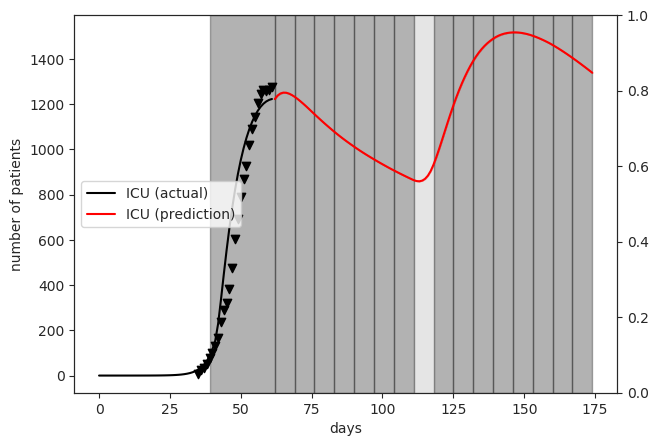

In [43]:
# -------------------------------------------------------
# Plot Belgian results first from march 13th untill today
# -------------------------------------------------------
plt.figure(1)
t=pd.date_range('2020-03-13', freq='D', periods=ICUvect.size+int(extraTime)+simtime+1)-datetime.timedelta(days=int(extraTime))
t = np.linspace(0,t.size,t.size+1)
plt.figure(figsize=(7,5),dpi=100)
plt.scatter(t[int(extraTime):int(extraTime)+27],data_belgie.iloc[:,1],color="black",marker="v")
plt.plot(t[0:int(extraTime)+27],np.mean(simout['CH'],axis=1),color="black")

# --------------
# Run simulation
# --------------
Nc = np.array([thetas1[0]])
if controlDoF == 1:
    totalTests = 0
elif controlDoF == 2:
    totalTests = thetas2[0]
simout=cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,totalTests,psi_FP,psi_PP,
                   dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC,initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,
                   initRQ,simtime,monteCarlo,n_samples,method,modelType,checkpoints)

# --------------------------
# Plot controller prediction
# --------------------------
plt.plot(t[int(extraTime)+27:-1],np.mean(simout['CH'],axis=1),color="red")
plt.fill_between(t[int(extraTime)+27:-1], np.percentile(simout['CH'],90,axis=1), np.percentile(simout['CH'],10,axis=1),color="red",alpha=0.2)
plt.legend(('ICU (actual)','ICU (prediction)'),loc='center left')
plt.xlabel('days')
plt.ylabel('number of patients')

thetas1[thetas1<5.6] = 0
thetas1[(thetas1>=5.6)&(thetas1<8)] = 1
thetas1[thetas1>=8] = 2
a = [0.3,0.10,0]


if period == 3:
    plt.axvspan(int(extraTime)+4, int(extraTime)+27, alpha=0.3, color='black')
    plt.axvspan(int(extraTime)+27, int(extraTime)+27+3, alpha=a[int(thetas1[0])], color='black')
    plt.axvspan(int(extraTime)+27+3, int(extraTime)+27+6, alpha=a[int(thetas1[1])], color='black')
    plt.axvspan(int(extraTime)+27+6, int(extraTime)+27+9, alpha=a[int(thetas1[2])], color='black')
    plt.axvspan(int(extraTime)+27+9, int(extraTime)+27+12, alpha=a[int(thetas1[3])], color='black')
    plt.axvspan(int(extraTime)+27+12, int(extraTime)+27+15, alpha=a[int(thetas1[4])], color='black')
    plt.axvspan(int(extraTime)+27+15, int(extraTime)+27+18, alpha=a[int(thetas1[5])], color='black')
    # als het negen intervallen is
    plt.axvspan(int(extraTime)+27+18, int(extraTime)+27+21, alpha=a[int(thetas1[6])], color='black')    
    plt.axvspan(int(extraTime)+27+21, int(extraTime)+27+24, alpha=a[int(thetas1[7])], color='black')
    plt.axvspan(int(extraTime)+27+24, int(extraTime)+27+27, alpha=a[int(thetas1[8])], color='black')
elif period == 7:
    plt.axvspan(int(extraTime)+4, int(extraTime)+27, alpha=0.3, color='black')
    plt.axvspan(int(extraTime)+27, int(extraTime)+27+7, alpha=a[int(thetas1[0])], color='black')
    plt.axvspan(int(extraTime)+27+7, int(extraTime)+27+14, alpha=a[int(thetas1[1])], color='black')
    plt.axvspan(int(extraTime)+27+14, int(extraTime)+27+21, alpha=a[int(thetas1[2])], color='black')
    plt.axvspan(int(extraTime)+27+21, int(extraTime)+27+28, alpha=a[int(thetas1[3])], color='black')
    plt.axvspan(int(extraTime)+27+28, int(extraTime)+27+35, alpha=a[int(thetas1[4])], color='black')
    plt.axvspan(int(extraTime)+27+35, int(extraTime)+27+42, alpha=a[int(thetas1[5])], color='black')
    # als het negen intervallen is
    plt.axvspan(int(extraTime)+27+42, int(extraTime)+27+49, alpha=a[int(thetas1[6])], color='black')    
    plt.axvspan(int(extraTime)+27+49, int(extraTime)+27+56, alpha=a[int(thetas1[7])], color='black')
    plt.axvspan(int(extraTime)+27+56, int(extraTime)+27+63, alpha=a[int(thetas1[8])], color='black')
    # als het er zestien zijn
    plt.axvspan(int(extraTime)+27+63, int(extraTime)+27+70, alpha=a[int(thetas1[9])], color='black')
    plt.axvspan(int(extraTime)+27+70, int(extraTime)+27+77, alpha=a[int(thetas1[10])], color='black')
    plt.axvspan(int(extraTime)+27+77, int(extraTime)+27+84, alpha=a[int(thetas1[11])], color='black')
    plt.axvspan(int(extraTime)+27+84, int(extraTime)+27+91, alpha=a[int(thetas1[12])], color='black')
    plt.axvspan(int(extraTime)+27+91, int(extraTime)+27+98, alpha=a[int(thetas1[13])], color='black')
    plt.axvspan(int(extraTime)+27+98, int(extraTime)+27+105, alpha=a[int(thetas1[14])], color='black')
    plt.axvspan(int(extraTime)+27+105, int(extraTime)+27+112, alpha=a[int(thetas1[15])], color='black')
elif period == 14:
    plt.axvspan(int(extraTime)+4, int(extraTime)+27, alpha=0.3, color='black')
    plt.axvspan(int(extraTime)+27, int(extraTime)+27+14, alpha=a[int(thetas1[0])], color='black')
    plt.axvspan(int(extraTime)+27+14, int(extraTime)+27+28, alpha=a[int(thetas1[1])], color='black')
    plt.axvspan(int(extraTime)+27+28, int(extraTime)+27+42, alpha=a[int(thetas1[2])], color='black')
    plt.axvspan(int(extraTime)+27+42, int(extraTime)+27+56, alpha=a[int(thetas1[3])], color='black')
    plt.axvspan(int(extraTime)+27+56, int(extraTime)+27+70, alpha=a[int(thetas1[4])], color='black')
    plt.axvspan(int(extraTime)+27+70, int(extraTime)+27+84, alpha=a[int(thetas1[5])], color='black')
    # als het negen intervallen is
    plt.axvspan(int(extraTime)+27+84, int(extraTime)+27+98, alpha=a[int(thetas1[6])], color='black')    
    plt.axvspan(int(extraTime)+27+98, int(extraTime)+27+112, alpha=a[int(thetas1[7])], color='black')
    plt.axvspan(int(extraTime)+27+112, int(extraTime)+27+126, alpha=a[int(thetas1[8])], color='black')
    
ax2 = plt.twinx()
totalTeststar = np.zeros(t.size)
totalTeststar[0:int(extraTime)+27] = 0
totalTeststar[int(extraTime)+27:-1] = totalTestsvect

plt.plot(t[0:-2],totalTeststar[0:-2],'--',color='black')
ax2.set_ylabel("Number of daily tracked infections")


plt.savefig('belgiumController.svg',dpi=100,bbox_inches='tight')

In [51]:
#A biotech company in Iceland that has tested more than 9,000 people found that around 50 percent 
#of those who tested positive said they were asymptomatic, the researchers told CNN.

model = models.SEIRSAgeModel(initN   = np.array([11.43e6]),
                                     beta    = 0.032, 
                                     sigma   = 5.2,
                                     Nc = np.array([11.2]),
                                     sm = 0.50,
                                     m = (1-0.50)*0.81,
                                     h = (1-0.50)*0.15,
                                     c = (1-0.50)*0.04,
                                     dsm = 14,
                                     dm = 14,
                                     dhospital = 1,
                                     dh = 21,
                                     dcf = 18.5,
                                     dcr = 22.0,
                                     mc0 = 0.49,
                                     ICU = 2000,
                                     totalTests = 0,
                                     psi_FP = 0,
                                     psi_PP = 1,
                                     dq = 14,
                                     initE = np.array([1]),
                                     initSM = np.zeros(1),
                                     initM = np.zeros(1),
                                     initH = np.zeros(1),
                                     initC = np.zeros(1),
                                     initHH = np.zeros(1),
                                     initCH = np.zeros(1),
                                     initR = np.zeros(1),
                                     initF = np.zeros(1),
                                     initSQ = np.zeros(1),
                                     initEQ = np.zeros(1),
                                     initSMQ = np.zeros(1),
                                     initMQ = np.zeros(1),
                                     initRQ = np.zeros(1),
                                     monteCarlo = False,
                                     n_samples = 50
                            )

y = model.sim(70)

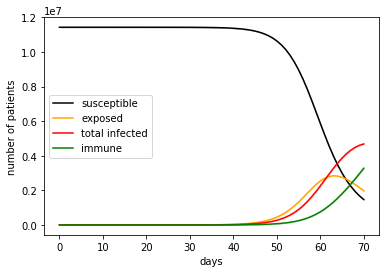

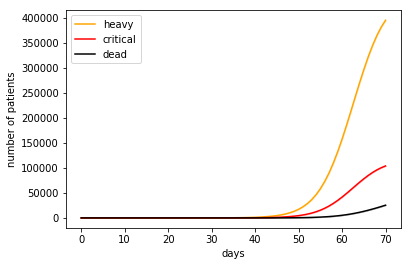

In [52]:
model.plotPopulationStatus()
model.plotInfected()

DatetimeIndex(['2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19'],
              dtype='datetime64[ns]', freq='D')
differential_evolution step 1: f(x)= 52098.4
differential_evolution step 2: f(x)= 52098.4
differential_evolution step 3: f(x)= 37889.2
differential_evolution step 4: f(x)= 16426.2
differential_evolution step 5: f(x)= 16426.2
differential_evolution step 6: f(x)= 16426.2
differential_evolution step 7: f(x)= 16426.2
differential_evolution step 8: f(x)= 16426.2
differential_evolution step 9: f(x)= 15773.1
differential_evolution step 10: f(x)= 15773.1
differential_evolution step 11: f(x)= 15773.1
differential_evolution step 12: f(x)= 8115.73
differential_evolution step 13: f(x)= 8115.73
differential_evolution step 14: f(x)= 8115.73
differential_evolution step 15: f(x)= 7776.99
differential_evolution step 16: f(x)= 7776.99
differential_evolution step 17: f(x)= 7776.99
differential_evolution step 18: f(x)= 7776.99
diff

<Figure size 432x288 with 0 Axes>

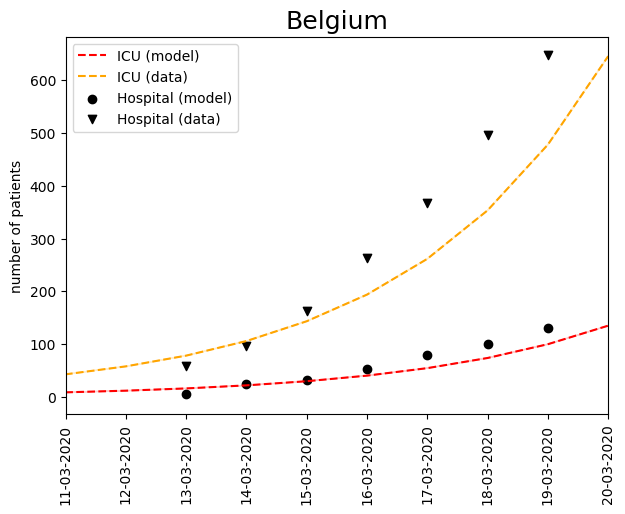

In [56]:
# make data vector
ICUvect= np.array([[5,24,33,53,79,100,130,164,238,290,322,381,474,605,690,789,867,927,1021,1088,1144,1205,1245,1261,1257,1260,1276,1285,1278,1262,1232,1234,1223]])
hospital = np.array([[58,97,163,264,368,496,648,841,1096,1380,1643,1881,2137,2715,3068,3640,4077,4468,4884,4975,5206,5358,5492,5509,5600,5738,5692,5590,5610,5635,5409,5393,5536]])
index=pd.date_range('2020-03-13', freq='D', periods=ICUvect.size)
idx=-26
index = index[0:idx]
print(index)
data=[np.transpose(ICUvect[:,0:idx]),np.transpose(hospital[:,0:idx])]
# set optimisation settings
bounds=[(10,60),(0.01,0.035)]
positions = [np.array([7]),np.array([6,7])]
# run optimisation
theta = model.fit(data,['beta'],positions,bounds,np.array([1,1]),setvar=True,maxiter=100)
model.plotFit(index,data,positions,modelClr=['red','orange'],legendText=('ICU (model)','ICU (data)','Hospital (model)','Hospital (data)'),titleText='Belgium')